In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def leaky_relu(self, alpha=0.01):
    """Leaky ReLU activation function: f(x) = x if x > 0 else alpha * x"""
    x = self.data
    t = x if x > 0 else alpha * x  # Apply Leaky ReLU transformation
    out = Value(t, (self,), 'leaky_relu')

    def _backward():
        self.grad += (1 if x > 0 else alpha) * out.grad  # Derivative of Leaky ReLU
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
# Defining variables
a = Value(-2.0, label='a')
b = Value(5.0, label='b')
c = Value(6.0, label='c')
d = Value(3.0, label='d')
e = Value(7.0, label='e')
f = Value(4.0, label='f')
g = Value(-6.0, label='g')

# New expression: L = ((a^2 + b - c) / d) * (e - f) + g
h = a**2; label = 'h'
i = h + b; label = 'i'
j = i - c; label = 'j'
k = j/d; label = 'k'
expr2 = e - f
L = k * expr2 + g
L.label = 'L'
o = L.leaky_relu()
# Combined expression: ((a^2 + b - c) / d) * (e - f) + g

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

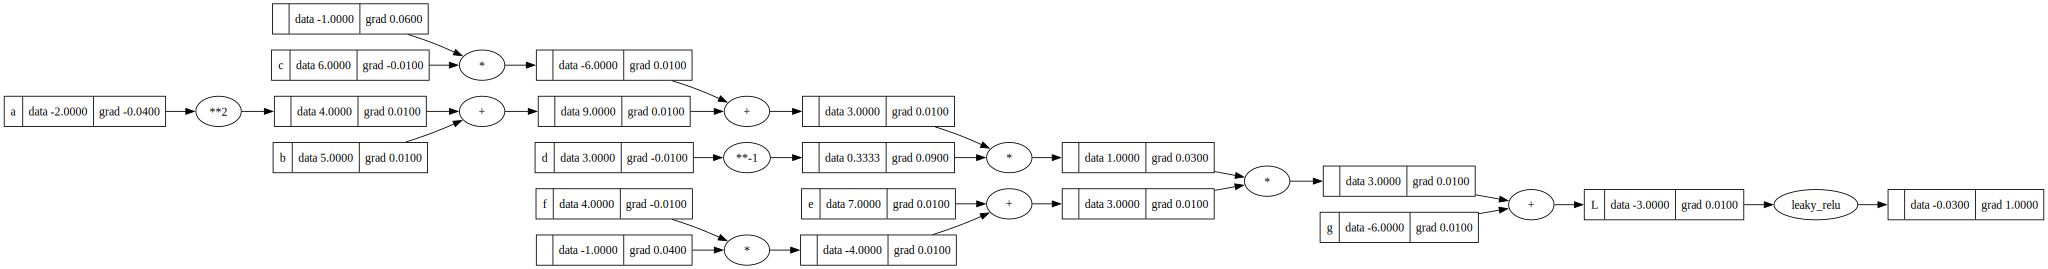

In [17]:
draw_dot(o)
# o = leaky_relu(((a^2 + b - c) / d) * (e - f) + g )

In [16]:
o.backward() # computes the gradients (Backward Pass)

Implementing a Simple Multi-Layer Perceptron (MLP) from Scratch for a different input & output data 

In [1]:
import random

In [218]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b 
    out = act.tanh()
    return out
    # print(list(zip(self.w,x)))
  
  def parameters(self):
    return self.w + [self.b]
  
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [382]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.3252058697777505)

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [0.5, -1.0, -0.7, 1.0] # desired targets


In [588]:
ypred = [n(x) for x in xs]
ypred 

[Value(data=0.45383284186222994),
 Value(data=-0.9756946440657686),
 Value(data=-0.7302669240296744),
 Value(data=0.9444003795594524)]

In [579]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for  ygt, yout in zip(ys, ypred)])
loss

Value(data=0.12885373241678802)

Loss Computation and Gradient Descent for Neural Network Training

In [572]:
loss.backward()

In [ ]:
for p in n.parameters():
    p.data += -0.001 * p.grad

In [587]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.007894420562363032
1 0.009156471363306096
2 0.0077621149218153685
3 0.008980734050215614
4 0.00763369254687625
5 0.008810964762439174
6 0.007509004821140678
7 0.008646889215941665
8 0.007387909558114438
9 0.0084882485020343
10 0.007270270733335027
11 0.008334798096633194
12 0.0071559582227263396
13 0.008186306940361899
14 0.0070448475478672445
15 0.008042556583855286
16 0.006936819628714707
17 0.007903340393176478
18 0.006831760544194822
19 0.007768462810727303
